In [23]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/flt_tokyo_region_wind_speed_hourly.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

#standardization

mean_value = np.mean(data)
std_dev    = np.std(data)
data_org = (data - mean_value) / std_dev

data = np.array(data, dtype=float)
data = data.T

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# @title Loading optuna and libraries
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import networkx as nx
import csv
import datetime

!pip install optuna
import optuna

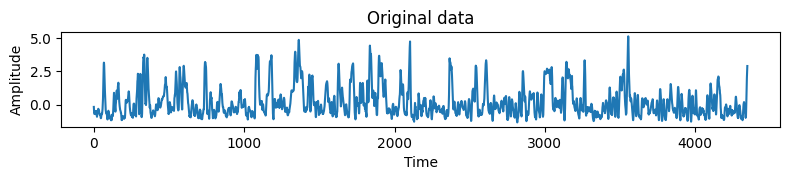

Data shape: (42, 4347)


In [25]:
# @title Visualization

plt.figure(figsize=(8, 3))
plt.subplot(2, 1, 1)
plt.plot(data[9,:])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

print('Data shape:',data.shape)

In [26]:
# @title Definition of Reservoir computing (without ``Class" setting!!)

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

# Separate integer and decimal portions
    seed_int_low  = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction      = seed_value - seed_int_low

# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

#Specify non-zero positions
def generate_random_binary_matrix(N_x, N_y, density, seed_value_binary):

    num_ones = int(N_x*N_y * density)
    matrix   = np.zeros(N_x*N_y, dtype=int)
    np.random.seed(seed_value_binary)
    ones_indices = np.random.choice(N_x*N_y, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, N_y))


def recurrent_matrix(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W


#############################
# reservoir state vector
#############################

def Reservoir(x_in,x,W,alpha,bias_scale):

        Wbias = np.ones(len(x_in))
        Wbias = Wbias * bias_scale

        x = (1.0 - alpha) * x \
                 + alpha * np.tanh(np.dot(W, x)+Wbias \
                 + x_in)
        return x

############################
#Ridge Regression and  Output Weight Matrix
############################

def Ridge(d, x, X_XT,D_XT):

        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        X_XT += np.dot(x, np.transpose(x))
        D_XT += np.dot(d, np.transpose(x))
        return X_XT, D_XT

def get_Wout_opt(X_XT,D_XT,N_x,beta):

        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x, T_train,Win,W,N_x,dim,alpha,discard_len,bias_scale):


    X_XT          = np.zeros((N_x, N_x))
    D_XT          = np.zeros((dim, N_x))
    x_special_vec = np.zeros((train_U.shape[0],N_x))

    for m in range(train_U.shape[0]):

        x = np.zeros(N_x)

        for n in range(T_train):

            # reservoir state vector
            x = Reservoir(np.dot(Win,train_U[m,n,:]),x,W,alpha,bias_scale)

            # teacher data
            d = train_D[m,n,:]


            if n > discard_len:  # discard the first part of the data
                 X_XT, D_XT = Ridge(d, x, X_XT, D_XT)

        x_special_vec[m,:] = x

    return X_XT, D_XT,x_special_vec


########################
#induction formula for creating estimated data
########################

def run(test_U,x,Win,W,Wout,alpha,T_test,bias_scale):


    Y_pred = []
    y = test_U[0,:]


    for n in range(T_test):

        x = Reservoir(np.dot(Win,y),x,W,alpha,bias_scale)
        y_pred = np.dot(Wout, x)
        Y_pred.append(y_pred)
        y = y_pred

    return np.array(Y_pred)

###############################
#MAE
###############################
from sklearn.metrics import mean_absolute_error

def MAE(data1_in, data2_in):

    mae = mean_absolute_error(data1_in, data2_in)
    return mae


In [27]:
# @title Hyperparameters

T_train      = 1000  # Training period
T_test       = 3     # Forecast period
discard_len  = 10    # Number of steps not learned at the beginning (not important)
initial_time = 0     # Starting training time

In [28]:
# @title Hyperparameters: Bayesian optimization for Reservoir

Node       = 80   # Reservoir Node
max_lag    = 1    # Maximum of lag for delay coordinate
max_dim    = 4    # Maximum of dimension for delay coordinate
test_num   = 1    # test numbers for each time series

In [29]:
# @title Implement set

impl_set = data[:,initial_time:initial_time+T_train+max_lag*max_dim+2*T_test+test_num]

print("data length from initial_time:",data[:,initial_time:].shape[1])
print("shape of implement set",impl_set.shape)

data length from initial_time: 4347
shape of implement set (42, 1011)


In [30]:
# @title Implementation of Bayesian optimization of Reservoir

%%time

####################
n_trials    = 50   # Number of times to test with optuna (generate MAE for this number of times)
####################

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

#####################################################
#We can load (in csv file) and reuse the past trials

file_path = 'reservoir.csv'
past_trials = []
if os.path.exists(file_path):


# Import data from CSV files

   with open(file_path, mode='r', newline='') as file:
       reader = csv.DictReader(file)
       for row in reader:
        # Data processing and incorporation into past_trials
           trial_data = {
               'value': float(row['value']),
               'params': {
                   'lag': int(row['lag']),
                   'dim': int(row['dim']),
                   'N_x': int(row['N_x']),
                   'beta': float(row['beta']),
                   'density': float(row['density']),
                   'input_scale': float(row['input_scale']),
                   'rho': float(row['rho']),
                   'alpha': float(row['alpha']),
                   'seed_value': float(row['seed_value']),
                   'bias_scale': float(row['bias_scale'])
               }
           }
           past_trials.append(trial_data)




# Creating an Optuna Study
study = optuna.create_study(direction="minimize")


############################
# Add past attempts to study
for trial in past_trials:

    if 'value' not in trial:
        print(f"Skipping trial as it does not contain 'value': {trial}")
        continue

    try:
          value = float(trial['value'])
    except ValueError as e:
          print(f"Error converting trial value to float: {e}")
          continue  # Proceed to the next TRIAL

    trial_id = len(study.trials)

    frozen_trial = FrozenTrial(
      number=trial_id,  # trial number
      state=TrialState.COMPLETE,
      value=trial['value'],
      datetime_start=datetime.now(),
      datetime_complete=datetime.now(),
      params=trial['params'],
      distributions={
          'lag': optuna.distributions.IntUniformDistribution(1, max_lag),
          'dim': optuna.distributions.IntUniformDistribution(2, max_dim),
          'N_x': optuna.distributions.IntUniformDistribution(Node, Node),
          'beta': optuna.distributions.FloatDistribution(0.0001, 0.0001),
          'density': optuna.distributions.FloatDistribution(0.001, 1),
          'input_scale': optuna.distributions.FloatDistribution(0, 1.5),
          'rho': optuna.distributions.FloatDistribution(0, 1.5),
          'alpha': optuna.distributions.FloatDistribution(0, 1),
          'seed_value': optuna.distributions.FloatDistribution(0, 100),
          'bias_scale': optuna.distributions.FloatDistribution(-1.5, 1.5)
      },
      user_attrs={},
      system_attrs={},
      intermediate_values={},
      trial_id=trial_id
    )
    study.add_trial(frozen_trial)
#################################
# Objective Function Definition

def objective(trial):
    lag = trial.suggest_int("lag", 1, max_lag)
    dim = trial.suggest_int("dim", 2, max_dim)
    N_x = trial.suggest_int("N_x", Node, Node)                #Initially fixed here
    beta = trial.suggest_float("beta", 0.0001, 0.0001)
    density = trial.suggest_float("density", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.5)
    rho = trial.suggest_float("rho", 0, 1.5)
    alpha = trial.suggest_float("alpha", 0, 1)
    seed_value = trial.suggest_float("seed_value", 0, 100)
    bias_scale = trial.suggest_float("bias_scale", -1.5, 1.5)

#############################
#Test start time (model selection)

    T_0 = T_train + lag * dim

#Initialization of estimated data

    data_delay_train = np.zeros((impl_set.shape[0],T_train+1,dim), dtype=float)
    cor_set          = np.zeros((impl_set.shape[0]), dtype = float)
    test_Y           = np.zeros((impl_set.shape[0],T_test,test_num))
    test_D           = np.zeros((impl_set.shape[0],T_test,test_num))

#Fix input and recurrent weight matrices

    Win= input_matrix(N_x,seed_value,input_scale,dim)
    W = recurrent_matrix(N_x, density, rho,seed_value)

##########################################
#Convert training data to a delay coordinate system

    for i in range(dim):

        data_delay_train[:,:,i] = impl_set[:,T_0-T_train-i*lag:T_0-i*lag+1] # i*lag Step-delayed time series


# Initialization of training data

    train_U = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)
    train_D = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)

#Input/output of training data

    train_U = data_delay_train[:,:T_train,:]
    train_D = data_delay_train[:,1:T_train+1,:]

##The last time data of the training data output must overlap with the test data,
##since non-increment online learning!

#Ridge
    X_XT          = np.zeros((N_x, N_x))
    D_XT          = np.zeros((dim, N_x))
    x_special_vec = np.zeros((train_U.shape[0],N_x))

    X_XT, D_XT,_ = train(train_U,train_D,np.zeros(N_x),T_train, \
                                  Win, W, N_x, dim, alpha,discard_len,bias_scale)

# Generate regression weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

#######################
# Model selection phase
    data_delay_test         = np.zeros((T_test+1,dim,test_num), dtype=float)
    tentative_test_Y        = np.zeros((T_test,dim,test_num))
    data_delay_train_resvec = np.zeros((impl_set.shape[0],T_train+1,dim,test_num), dtype=float)

#Convert training data to a delay coordinate system (to create reservoir state vec)

    for t in range(test_num):

        for i in range(dim):

            data_delay_train_resvec[:,:,i,t] = impl_set[:,T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series

    # Initialization of training data

        train_U = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)
        train_D = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)

    #Input/output of training data

        train_U[:,:,:] = data_delay_train_resvec[:,:T_train,:,t]
        train_D[:,:,:] = data_delay_train_resvec[:,1:T_train+1,:,t]

    ##The last time data of the training data output must overlap with the test data!

    #Ridge
        X_XT = np.zeros((N_x, N_x))
        D_XT = np.zeros((dim, N_x))
        x_special = np.zeros(N_x)

        _, _,x_special_vec = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)



##############################
#test in model selection phase

        for j in range (impl_set.shape[0]):

            for i in range(dim):

                data_delay_test[:,i,t] = impl_set[j,T_0-i*lag+t:
                                                T_0+T_test-i*lag+t+1] # i*lag step delayed time series


#Generate estimated data


            tentative_test_Y[:,:,t] = run(data_delay_test[:T_test,:,t],x_special_vec[j,:], \
                                          Win,W,Wout,alpha,T_test,bias_scale)
            test_Y[j,:,t] = tentative_test_Y[:,0,t]
            test_D[j,:,t] = data_delay_test[1:T_test+1,0,t]

    return MAE(test_Y[:,T_test-1,:],test_D[:,T_test-1,:])

#############
# Perform optimization
study.optimize(objective, n_trials)

# Display of optimization results
print("Best trial:")
trial = study.best_trial
print(f"  'params': {trial.params},")
print(f"  'value': {trial.value},")

###################
# Write to CSV file

current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'reservoir.csv')



# Write additional CSV files with the latest trial data

with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)

# Writing header lines (first time only)
    if file.tell() == 0:
        writer.writerow(['value', 'lag', 'dim', 'N_x', 'beta', 'density', 'input_scale', 'rho', 'alpha', 'seed_value', 'bias_scale'])

    # Write all trials
    for trial in study.trials:
        lag_value = trial.params.get('lag')
        if lag_value is not None:  # Write only if lag is not None
           writer.writerow([
    #trial.number,
    trial.value,
    trial.params.get('lag', None),
    trial.params.get('dim', None),
    trial.params.get('N_x', None),
    trial.params.get('beta', None),
    trial.params.get('density', None),
    trial.params.get('input_scale', None),
    trial.params.get('rho', None),
    trial.params.get('alpha', None),
    trial.params.get('seed_value', None),
    trial.params.get('bias_scale', None)
])

[I 2025-08-19 05:13:57,464] A new study created in memory with name: no-name-610dcb32-21b3-4a80-a9ab-f63230217cd0
<timed exec>:72: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
<timed exec>:73: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
<timed exec>:74: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
[I 2025-08-19 05:14:07,048] Trial 100 finished with value: 0.2364975567051563 and parameters: {'lag': 1, 'dim': 2, 'N_x': 80, 'beta': 0.0001, 'density': 0

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 80, 'beta': 0.0001, 'density': 0.7040069417623926, 'input_scale': 0.14047275711673762, 'rho': 1.1890799029508232, 'alpha': 0.8031659950864556, 'seed_value': 59.11475963047936, 'bias_scale': 0.36552059965726547},
  'value': 0.22093181615143923,
CPU times: user 3min 6s, sys: 382 ms, total: 3min 7s
Wall time: 3min 15s


In [31]:
# @title Best hyperparameters

best_params = study.best_params

lag          = best_params["lag"]
dim          = best_params["dim"]
N_x          = best_params["N_x"]
beta         = best_params["beta"]
density      = best_params["density"]
input_scale  = best_params["input_scale"]
rho          = best_params["rho"]
alpha        = best_params["alpha"]
seed_value   = best_params["seed_value"]
bias_scale   = best_params["bias_scale"]

print(f"initial_time= {initial_time}")
print(f"max_lag= {max_lag}")
print(f"max_dim= {max_dim}")
print(f"lag= {lag}")
print(f"dim= {dim}")
print(f"N_x= {N_x}")
print(f"beta= {beta}")
print(f"density= {density}")
print(f"input_scale= {input_scale}")
print(f"rho= {rho}")
print(f"alpha= {alpha}")
print(f"seed_value= {seed_value}")
print(f"bias_scale= {bias_scale}")


initial_time= 0
max_lag= 1
max_dim= 4
lag= 1
dim= 2
N_x= 80
beta= 0.0001
density= 0.7040069417623926
input_scale= 0.14047275711673762
rho= 1.1890799029508232
alpha= 0.8031659950864556
seed_value= 59.11475963047936
bias_scale= 0.36552059965726547


In [32]:
# @title Training in Model Evaluation phease

%%time

###############################
#Test start time (model evaluation)
#NOT T_0 = T_train+lag*dim!!

T_0 = T_train+lag*dim+T_test+test_num-1

#Generate Win and W

Win = input_matrix(N_x,seed_value,input_scale,dim)
W   = recurrent_matrix(N_x, density, rho,seed_value)

data_delay_train = np.zeros((impl_set.shape[0],T_train+1,dim), dtype=float)


#Convert training data to a delay coordinate system

for i in range(dim):

    data_delay_train[:,:,i] = impl_set[:,T_0-T_train-i*lag:T_0-i*lag+1] # i*lag step delayed time series

# Initialization of training data

train_U = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)
train_D = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)


#Input/output of training data

train_U = data_delay_train[:,:T_train,:]
train_D = data_delay_train[:,1:T_train+1,:]

##The last time data of the training data output must overlap with the test data!

#Ridge
X_XT = np.zeros((N_x, N_x))
D_XT = np.zeros((dim, N_x))

X_XT, D_XT,_ = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)

#Generate output weight matrix
Wout= None
Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

CPU times: user 2.47 s, sys: 14.9 ms, total: 2.48 s
Wall time: 3.26 s


MAE: [0.11180828 0.12704212 0.44159113 0.27504464 0.22204919 0.10371139
 0.31968536 0.11614786 0.36647529 0.34909128 0.44159113 0.08828497
 0.41075991 0.20320803 0.10615327 0.65429712 0.12094912 0.11180828
 0.34280861 0.3631325  0.29193716 0.01156281 0.24358571 0.23073317
 0.48665367 0.18193373 0.15146944 0.11806764 0.34909128 0.09994117
 0.33803882 0.48744538 0.40036823 0.45561279 0.31809365 0.37859828
 0.09994117 0.34909128 0.16698703 0.23694513 0.23073317 0.08408896]
MAE mean: 0.26158474131538945
forecast period: 3


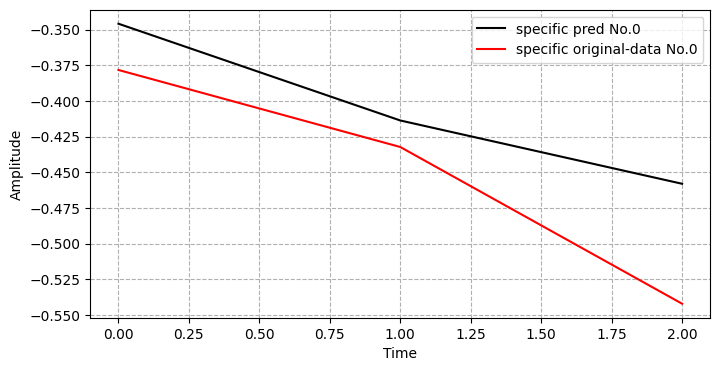

CPU times: user 2.84 s, sys: 26.9 ms, total: 2.87 s
Wall time: 3.63 s


In [33]:
# @title Implementation of Model Evaluation

%%time

np.random.shuffle(impl_set)

data_delay_train_resvec = np.zeros((T_train+1,dim,test_num), dtype=float)
data_delay_test         = np.zeros((T_test+1,dim,test_num), dtype=float)
test_Y                  = np.zeros((T_test,test_num))
test_D                  = np.zeros((T_test,test_num))
tentative_test_Y        = np.zeros((T_test,dim,test_num))

mae                     = np.zeros((impl_set.shape[0]),dtype=float)
#####################################################
##Convert training data to a delay coordinate system (to create reservoir state vec)

for j in range (impl_set.shape[0]):

    for t in range(test_num):

        for i in range(dim):

              data_delay_train_resvec[:,i,t] = impl_set[j,T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series

    # Initialization of training data

        train_U = np.zeros((1,T_train,dim), dtype=float)
        train_D = np.zeros((1,T_train,dim), dtype=float)

    #Input/output of training data

        train_U[0,:,:] = data_delay_train_resvec[:T_train,:,t]
        train_D[0,:,:] = data_delay_train_resvec[1:T_train+1,:,t]

    ##The last time data of the training data output must overlap with the test data!

    #Ridge
        X_XT = np.zeros((N_x, N_x))
        D_XT = np.zeros((dim, N_x))
        x_special = np.zeros(N_x)

        _, _,x_special = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)

        x_special = x_special.squeeze()


        #Convert test data to a delay coordinate system

        for i in range(dim):

              data_delay_test[:,i,t] = impl_set[j,T_0+t-i*lag
                                            :T_0+t+T_test-i*lag+1] # i*lag step delayed time series


      #Predictive data generation

        tentative_test_Y[:,:,t] = run(data_delay_test[:T_test,:,t],x_special,Win,W,Wout,alpha,T_test,bias_scale)
        test_Y[:,t] = tentative_test_Y[:,0,t]
        test_D[:,t] = data_delay_test[1:T_test+1,0,t]

# Calculate MAE
    mae[j] = MAE(test_Y[T_test-1,:],test_D[T_test-1,:])

mae_mean = np.mean(mae)
########################
print("MAE:", mae)
print("MAE mean:", mae_mean)
print("forecast period:", T_test)

# fig = plt.figure(figsize=(8,3), dpi=100)
# plt.rcParams["font.size"] = 15
# plt.grid(which='major', linestyle='--', axis='both')
# plt.xlabel("Lag (the last trial)")
# plt.ylabel("Amplitude")
# plt.plot(test_Y[T_test-1,:], color="black", label=f"pred for {test_num} times")
# plt.plot(test_D[T_test-1,:], color = "red",label=f"data for {test_num} times")
# plt.legend()#loc='lower right')
# plt.tight_layout()
# plt.show()

fix_test_num = 0

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(test_Y[:,fix_test_num], color = "black",label=f"specific pred No.{fix_test_num}")
plt.plot(test_D[:,fix_test_num], color = "red",label=f"specific original-data No.{fix_test_num}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()